In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from slam.motion_models.odometry_model import odometry_sample, odometry_command
from slam.utils import normalize_angle
from slam.robot import BaseRobot
from slam.map import LandmarkMap
from slam.data import read_simple_world, read_simple_data
from slam.ukf import UKF, odometry_model_transform, measurement_model_transform, \
    compute_sigma_points, recover_gaussian

c:\projects\slam-algorithms\slam\ukf.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  sigma_points[:,[i]] = mu + mroot[:, [i-1]]
c:\projects\slam-algorithms\slam\ukf.py:180: ComplexWarning: Casting complex values to real discards the imaginary part
  sigma_points[:,[i]] = mu - mroot[:, [i-n-1]]


[[  5.62842584]
 [ 20.39183461]
 [  1.23897873]]
[[  2.97973942e-04  -2.05424300e-02   6.31827909e-04]
 [ -2.05424300e-02  -6.81572336e-01   1.52199419e-02]
 [  6.31827909e-04   1.52199419e-02  -3.15847147e-05]]


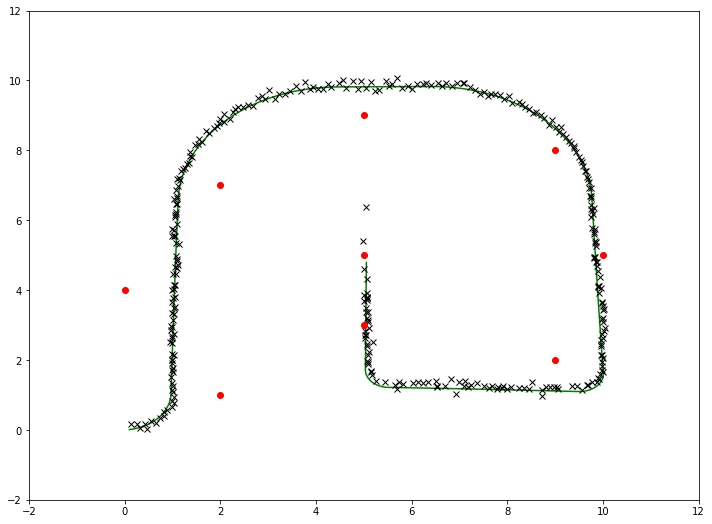

In [3]:
robot = BaseRobot(0, 0, 0, odometry_command)

odometry, sensor = read_simple_data('./data/simple/sensor_data.dat')
landmarks = read_simple_world('./data/simple/world.dat')

commands = [np.array(odom).T for odom in odometry]

landmark_map = LandmarkMap(landmarks)

ukf = UKF(robot.pose)

fig = plt.figure(figsize=(12, 9))
plt.xlim((-2, 12))
plt.ylim((-2, 12))

true_x = []
true_y = []
ukf_x = []
ukf_y = []

# Odometry noise
# rot1 variance, trans variance, rot2 variance
odometry_noise = (0.001, 0.01, 0.001)

# Sensor noise
# range variance, bearing variance
sensor_noise = (0.01, 0.01)

odom_sens_data = zip(odometry, sensor)
# For debugging
# odom_sens_data = list(zip(odometry, sensor))[:125]

for command, readings in odom_sens_data:
    robot.motion_command(command)
    
    ukf.predict(odometry_model_transform, command, odometry_noise)
    ukf.correct(measurement_model_transform, readings, sensor_noise, landmark_map)
    
    true_x.append(robot.pose.item(0))
    true_y.append(robot.pose.item(1))
    ukf_x.append(ukf.mean.item(0))
    ukf_y.append(ukf.mean.item(1))
    
plt.plot(true_x, true_y, 'g')
plt.plot(ukf_x, ukf_y, 'kx')

for key, value in landmark_map.landmarks.items():
    plt.plot(value[0], value[1], 'ro')
    
print(ukf.mean)
print(ukf.cov)